# Convolutional Autoencoders


An autoencoder is a type of neural network architecture that aims to copy its input to its output by learning an efficient, compressed representation of the data. It functions through two main components: an encoder that compresses the input into a low dimensional layer, also known as a latent space, and a decoder that attempts to reconstruct the original input from that compressed layer. By forcing the data through this bottleneck, the network cannot just memorize the input, instead, it learns the most essential features, patterns, and structures to achieve a good reconstruction.

## Functions

In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotly.express as px
from tensorflow.keras.models import Model
import pandas as pd
from tqdm import tqdm
import pickle

### Build Autoencoder

In [2]:
def build_autoencoder(input_shape=(32, 32, 3), 
                      latent_filters=16, 
                      kernel_size=(3, 3),
                      output_channels=3,
                      remove_layer=True,
                      padding='same',
                      strides=1):
    
    # Input layer
    input_layer = tf.keras.layers.Input(shape=input_shape)
    
    # Encoder
    x = tf.keras.layers.Conv2D(8, kernel_size, activation='relu', padding=padding, strides=strides)(input_layer)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding=padding)(x)
    if remove_layer:
        x = tf.keras.layers.Conv2D(12, kernel_size, activation='relu', padding=padding, strides=strides)(x)
        x = tf.keras.layers.MaxPooling2D((2, 2), padding=padding)(x)
    
    # Latent Space
    encoded = tf.keras.layers.Conv2D(latent_filters, kernel_size, activation='relu', padding=padding)(x)

    # Decoder
    if remove_layer:
        x = tf.keras.layers.UpSampling2D((2, 2))(encoded)
        if strides > 1:
            x = tf.keras.layers.UpSampling2D((strides, strides))(x)
        x = tf.keras.layers.Conv2D(12, kernel_size, activation='relu', padding=padding)(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x if remove_layer else encoded)
    if strides > 1:
        x = tf.keras.layers.UpSampling2D((strides, strides))(x)
    decoded = tf.keras.layers.Conv2D(output_channels, kernel_size, activation='sigmoid', padding=padding)(x)
    
    # Create the autoencoder model
    autoencoder = tf.keras.models.Model(input_layer, decoded)

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    
    return autoencoder

### Train Autoencoder

In [3]:
def train_autoencoder(autoencoder, x_train, x_val, epochs = 50, y_train = None, y_val = None):
    
    if y_train is None:
        y_train = x_train

    if y_val is None:
        y_val = x_val
    
    # Train the autoencoder
    train_history = autoencoder.fit(x_train, y_train,
                    epochs=epochs,
                    batch_size=256,
                    shuffle=True,
                    validation_data=(x_val, y_val))
    
    return train_history

### Evaluate Autoencoder

In [4]:
def evaluate_autoencoder(autoencoder, x_test):
    # Evaluate the autoencoder
    test_loss = autoencoder.evaluate(x_test, x_test)
    print(f'Test Loss: {test_loss}')

    return test_loss

### Plot images

In [5]:
def plot_images(models_list, model_names, images, n=10, graymap=False):
    
    # Get predictions from all models first
    all_predictions = []
    for model in models_list:
        predictions = model.predict(images[:n])
        all_predictions.append(predictions)

    # Set up the matplotlib plot
    num_models = len(models_list)
    num_rows = 1 + num_models  
    
    # Create a grid with 'n' cols and 'num_rows' rows
    fig, axes = plt.subplots(num_rows, n, figsize=(n * 1.0, num_rows * 0.75))

    # Loop and display the images
    for i in range(n):
        
        # Original Image ---
        ax_orig = axes[0, i]
        ax_orig.imshow(images[i], cmap='gray' if graymap else 'viridis')
        ax_orig.axis('off')
        if i == 0:
            ax_orig.set_title("Original", fontsize=10)

        # Subsequent Rows: Model Reconstructions
        for j in range(num_models):
            ax_recon = axes[j + 1, i]
            
            # Get the correct prediction: from the j-th model, the i-th image
            recon_img = all_predictions[j][i]
            recon_img = np.clip(recon_img, 0, 1)
            
            ax_recon.imshow(recon_img)
            ax_recon.axis('off')
            if i == 0:
                ax_recon.set_title(model_names[j], fontsize=10)

    plt.tight_layout(pad=0)
    plt.show()

In [6]:
import plotly.graph_objects as go

def plot_comparison_full(df, experiment="All Experiments"):

    fig = go.Figure()
    experiments = df['Experiment'].unique()
    colors = px.colors.qualitative.Plotly[:len(experiments)]
    color_map = dict(zip(experiments, colors))
    
    for index, row in df.iterrows():
        history = row['History']
        name = row['Experiment']
        epochs = list(range(1, len(history['loss']) + 1))
        exp_color = color_map.get(name, 'black')
        
        # 1. Add Training Loss (Dashed)
        fig.add_trace(go.Scatter(
            x=epochs, 
            y=history['loss'],
            mode='lines',
            name=f'{name} (Train)',
            line=dict(dash='dash', color=exp_color),
            legendgroup=name
        ))

        # 2. Add Validation Loss (Solid)
        fig.add_trace(go.Scatter(
            x=epochs, 
            y=history['val_loss'],
            mode='lines',
            name=f'{name} (Val)',
            line=dict(dash='solid', color=exp_color),
            legendgroup=name
        ))

    fig.update_layout(
        title=f'Comparison: Training vs Validation Loss - {experiment}',
        xaxis_title='Epoch',
        yaxis_title='Loss (MSE)',
        legend_title='Experiment',
        template='plotly_white',
        height=600
    )
    fig.show()

In [7]:
def plot_training_history(train_history):
    # Plot training & validation loss values
    fig = px.line(x=train_history.epoch, 
                  y=[train_history.history['loss'], train_history.history['val_loss']],
                  labels={'x': 'Epoch', 'y': 'Loss'},
                  title='Model Loss')
    fig.update_layout(legend_title_text='Legend')
    fig.data[0].name = 'Train Loss'
    fig.data[1].name = 'Validation Loss'
    fig.show()

In [8]:
def plot_lab_images(autoencoder, X_test_rgb, num_images=8):
    
    # Ensure we don't try to sample more than we have
    sample_size = min(num_images, len(X_test_rgb))
    indices = random.sample(range(len(X_test_rgb)), sample_size)
    
    fig, axes = plt.subplots(2, sample_size, figsize=(sample_size * 1.0, 2.0))
    
    for i, idx in enumerate(indices):
        original_rgb = X_test_rgb[idx]
        lab_image = color.rgb2lab(original_rgb)
        
        # Extract L, Normalize L
        L_channel = lab_image[:, :, 0]
        L_input = L_channel / 100.0 
        
        # Reshape for model
        model_input = L_input.reshape(1, 32, 32, 1) 
        
        # Predict
        predicted_ab = autoencoder.predict(model_input) 
        predicted_ab = predicted_ab[0] 
        
        # Denormalize
        predicted_ab = (predicted_ab * 255.0) - 128.0
        
        # Reconstruction of the image
        L_for_recon = L_channel.reshape(32, 32, 1)
        reconstructed_lab = np.concatenate((L_for_recon, predicted_ab), axis=2)
        reconstructed_rgb = color.lab2rgb(reconstructed_lab)
        
        # Row 0: Grayscale Inputs
        axes[0, i].imshow(L_channel, cmap='gray')
        axes[0, i].axis('off')
        
        # Row 1: Colorized Outputs
        axes[1, i].imshow(reconstructed_rgb)
        axes[1, i].axis('off')

        
        # Optional: Add titles only to the first column to save space
        if i == 0:
            axes[0, i].set_title("Input (Gray)", fontsize=10, loc='left')
            axes[1, i].set_title("Autoencoder", fontsize=10, loc='left')

    plt.tight_layout()
    plt.show()

### Calculate SSIM

In [9]:
def calculate_ssim(autoencoder, x_test, graymap=False):
    
    y_test = x_test
    if graymap:
        x_test = tf.image.rgb_to_grayscale(x_test)
    
    reconstructed = autoencoder.predict(x_test)
    
    # Clip values to be strictly between 0 and 1
    # just in case of minor numerical instabilities.
    y_test = np.clip(y_test, 0., 1.)
    reconstructed = np.clip(reconstructed, 0., 1.)
    
    # SSIM (Structural Similarity Index)
    # Measures perceptual difference (luminance, contrast, structure).
    ssim_values = tf.image.ssim(y_test, reconstructed, max_val=1.0)
    ssim_score = tf.reduce_mean(ssim_values).numpy()
    
    return ssim_score

### RGB to LAB

In [36]:
from skimage import color
def rgb_to_lab(images):
    lab_img = color.rgb2lab(images)

    # Split channels
    X_l = lab_img[:, :, :, 0]
    X_ab = lab_img[:, :, :, 1:]
    
    # Normalize to [0,1]
    X_l = X_l / 100
    X_ab = (X_ab + 128) / 255

    return X_l, X_ab

## Exercise 1

For the first exercise, we will build an autoencoder based on the architecture shown below. The implementation consists of the following layers:

- Convolutional layer, with 8 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Max Pooling layer, with a pool size of 2x2
- Convolutional layer, with 16 filters of size 3x3 (Latent space)
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 12 filters of size 3x3
- Upsampling layer, with a pool size of 2x2
- Convolutional layer, with 3 filters of size 3x3

<center>
<img src="images/image1.png" alt="Autoencoder" width="500">
</center>

### Getting data

The dataset was obtained using the Keras library. Although Keras provides a defined split function, the data was concatenated and splitted to allow for custom training and testing percentages. Following this, the data was normalized by scaling the pixel values from the original range of [0, 255] to [0, 1].

In [11]:
def get_data():
    # Load data
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    x_full = np.concatenate((x_train, x_test), axis=0)
    y_full = np.concatenate((y_train, y_test), axis=0)

    # Split data
    x_train, x_temp, y_train, y_temp = train_test_split(x_full, y_full, test_size=0.2, random_state=42)
    x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    print(f"Training set shape: {x_train.shape}, {y_train.shape}")
    print(f"Validation set shape: {x_val.shape}, {y_val.shape}")
    print(f"Test set shape: {x_test.shape}, {y_test.shape}")

    # Normalization - Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255
    x_val = x_val.astype("float32") / 255
    x_test = x_test.astype("float32") / 255

    # Convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)

    #Return data
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [12]:
# Load and preprocess data
(x_train, y_train), (x_val, y_val), (x_test, y_test) = get_data()

Training set shape: (48000, 32, 32, 3), (48000, 1)
Validation set shape: (6000, 32, 32, 3), (6000, 1)
Test set shape: (6000, 32, 32, 3), (6000, 1)


### Building Autoencoder

The autoencoder follows the architecture defined above, the following configuration is used:

- **Input**: An input layer of 32x32x3 dimensions is used to represent the input image.

- **Convolutional Layers**: Five convolutional layers, all of them uses filters of size 3x3, a stride of 1, and 'same' padding to preserve the spatial dimensions of the feature maps. These layers use RELU as activation function.

- **Pooling Layers**: Two max pooling layers, each with a pool size of 2x2 and a stride of 2, are used to downsample the layers. These layers are used in the encoder part.

- **Upsampling Layers**: Two upsampling layers, each with a pool size of 2x2 and a stride of 2, are used to upsample the layers.

- **Output Activation**: A sigmoid function is used in the output layer to ensure the reconstructed pixel values fall within the [0, 1] interval.

- **Optimizer**: The Adam algorithm is utilized for training to leverage its momentum and adaptive learning rate capabilities. 

In [13]:
# Experiment 0 - Baseline
results_list = []
exp_name = "Baseline"
params = {'input_shape': '(32, 32, 3)', 
          'latent_filter':16, 
          'kernel_size':'(3, 3)',
          'remove_layer':True,
          'padding':'same',
          'strides':1}
# Build the autoencoder
autoencoder = build_autoencoder()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

In the summary table of the autoencoder we can notice that it has 4911 trainable parameters. It means that it has 4911 weights and biases that are being optimized during training.

### Training

In [14]:
# Hardcode parameters
epochs = 20 

In [15]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder, x_train, x_val, epochs=epochs)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0226 - val_loss: 0.0123
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0083 - val_loss: 0.0079
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0072 - val_loss: 0.0070
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

### Evaluation

First let's evaluate what is the loss value from out test dataset

In [16]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder, x_test)

# Store results
results_list.append({
    'Experiment': exp_name,
    'Test MSE': test_loss,
    'Val Loss': train_history.history['val_loss'][-1],
    'History': train_history.history,
    'Parameters': str(params)
})

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052
Test Loss: 0.005196564830839634


We are getting a loss value very close to 0. That means the autoencoder is able to reconstruct the input data very well.

Now let's check a plot of the loss over epochs.


In [17]:
# Plot training history
plot_training_history(train_history)

The training plot demonstrates excellent generalization, as evidenced by the near overlap between the training loss and validation loss curves, this confirms the autoencoder is not overfitting the dataset. The smooth, consistent decline in both curves throughout the training process is suggesting the Adam optimizer is doing a good job localizing the global minimum. By the final epochs, the clear flattening of both lines signifies that the model has converged, indicating that the autoencoder has successfully learned the most important patterns in the data.

Now let's pass some images of our dataset and see how the autoencoder performs.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


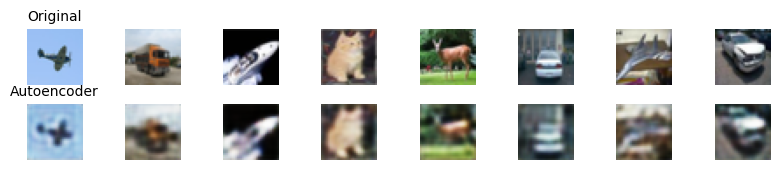

In [18]:
# Plotting images
plot_images([autoencoder], ['Autoencoder'], images = x_test, n = 8)

We can see that each image is reconstructed with an acceptable quality. The autoencoder was able to recognize the patterns and general features of the images.

Now we will calculate the Structural Similarity Index Measure (SSIM). This metric measures the similarity between two images by modeling how the human perceive the images. It works by comparing the luminance, contrast and structure of the images. The resulting score, which ranges from -1 to 1, indicates the quality of the reconstruction.

In [19]:
ssim_score = calculate_ssim(autoencoder, x_test)
print("SSIM score:", ssim_score)

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
SSIM score: 0.75595474


We got a SSIM of 0.78 which is a good result that indicates that reconstruction is almost similar to the original image.

## Exercise 2

### 2.1 Latent space size
To compute the size of the latent representation, we use the standard formula for the spatial output size of a convolutional layer:
$$
Size = \left( \frac{W - K + 2P}{S} + 1 \right)^2 * C
$$

Where:
- $W$: Input volume
- $K$: Kernel size (filter size)
- $P$: Padding
- $S$: Stride
- $C$: Number of channels

*Latent layer input:*
- In our implementation, the encoder reduces the image spatial dimensions from: $32×32→16×16→8×8$
- After the two max-pooling operations, the tensor entering the latent convolution has shape: $8×8×12$
- Then, we apply a Conv2D layer with 16 filters ($C =16$) to produce the latent representation.

So:
- $W = 8 x 8 = 8$
- $K = 3 x 3 = 3$
- $P = 1 $
- $S = 1$
- $C = 16$

So:
- $Size = \left( \frac{8 - 3 + 2(1)}{1} + 1 \right)^2 * 16 = 64 * 16 = 1024$

This means the bottleneck encodes each image as a tensor of shape: $8×8×16$ for a total of 1024 latent features.

The bottleneck forces the model to compress the input into a compact representation, capturing only essential features like shapes and colors. This restriction prevents simple memorization, ensuring the network learns the underlying patterns necessary to reconstruct the image efficiently.




### 2.2 Other architectures
#### 2.2.1. Experiment 1 - Latent space variations
The comparison shows that latent space size has a clear impact on reconstruction performance. The small-latent model consistently exhibits the highest loss, indicating insufficient representational capacity. The baseline performs moderately well, while the large latent space (32) achieves the lowest training and validation errors throughout training.

Despite the stability of the training curves suggesting no immediate overfitting, the reduced compression ratio in the larger models implies a shift toward trivial identity mapping rather than the meaningful abstraction seen in tighter bottlenecks

In [20]:
def run_experiments(variations, epochs, results_list):
    for var in tqdm(variations):
        
        # 1. Build
        model = build_autoencoder(input_shape=(32, 32, 3), **var['params'])
        
        # 2. Train
        hist = train_autoencoder(model, x_train, x_val, epochs=epochs)
        
        # 3. Evaluate
        test_loss = evaluate_autoencoder(model, x_test)
        
        # 4. Store
        results_list.append({
            'Experiment': var['name'],
            'Test MSE': test_loss,
            'Val Loss': hist.history['val_loss'][-1],
            'History': hist.history,
            'Parameters': str(var['params'])
        })

In [21]:
# Store setups
variations = [
    {'name': 'Small Latent (4)', 'params': {'latent_filters': 4}},
    {'name': 'Large Latent (32)', 'params': {'latent_filters': 32}}
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 4)        │           436 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 16, 16, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 12)     │           444 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307 (9.01 KB)

 Trainable params: 2,307 (9.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0263 - val_loss: 0.0135
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0090 - val_loss: 0.0088
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0081 - val_loss: 0.0080
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 1/2 [02:02<02:02, 122.23s/it]

Test Loss: 0.006252804305404425


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 32)       │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 12)     │         3,468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,383 (32.75 KB)

 Trainable params: 8,383 (32.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 0.0215 - val_loss: 0.0110
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 0.0079 - val_loss: 0.0082
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0068 - val_loss: 0.0066
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━

100%|██████████| 2/2 [04:40<00:00, 140.24s/it]

In [22]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Small Latent (4)', 'Large Latent (32)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
0,Baseline,0.005197,0.005168,"{'loss': [0.022563539445400238, 0.010303162038...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
1,Small Latent (4),0.006253,0.006230,"{'loss': [0.026280228048563004, 0.011451145634...",{'latent_filters': 4}
2,Large Latent (32),0.004987,0.004964,"{'loss': [0.021464381366968155, 0.009437897242...",{'latent_filters': 32}


In [23]:
# Plot comparison
plot_comparison_full(df_current, experiment="Latent Space Variations")

#### 2.2.2. Experiment 2 - Modify kernel size
The analysis confirms that kernel size plays a decisive role in reconstruction quality, largely because it dictates how much spatial and color information the model processes at once. Since the model must interpret RGB images, having a sufficient 'field of view' is critical. The results show that small kernels (2×2) are ineffective; they are simply too narrow to capture meaningful patterns or textures, leading to consistently high error rates. In contrast, the baseline 3×3 kernels strike the optimal balance. They are large enough to recognize key features like edges and color transitions but remain computationally efficient. While larger kernels (5×5) can capture a broader context and achieve slightly lower loss, this comes at the cost of added complexity and a tendency to blur fine details ('over-smoothing'). Therefore, the 3×3 configuration proves to be the most robust choice, avoiding the limitations of the smaller kernels while maintaining better clarity than the larger ones.

In [24]:
# Store setups
variations = [
    {'name': 'Kernel (2,2)', 'params': {'kernel_size': (2,2)}},
    {'name': 'Kernel (5,5)', 'params': {'kernel_size': (5,5)}}
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 8)      │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 12)     │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 16)       │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 12)     │           780 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 3)      │           147 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,211 (8.64 KB)

 Trainable params: 2,211 (8.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0294 - val_loss: 0.0148
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0131 - val_loss: 0.0121
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 1/2 [01:57<01:57, 117.54s/it]

Test Loss: 0.007735522463917732


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 8)      │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 16, 16, 12)     │         2,412 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 8, 8, 16)       │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_8 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 12)     │         4,812 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 3)      │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,551 (52.93 KB)

 Trainable params: 13,551 (52.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 55ms/step - loss: 0.0230 - val_loss: 0.0125
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0114 - val_loss: 0.0101
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0089 - val_loss: 0.0083
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0083 - val_loss: 0.0082
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0070 - val_loss: 0.0072
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 12/20
188/188 ━━━━━━━━━━

100%|██████████| 2/2 [05:20<00:00, 160.18s/it]

In [25]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Kernel (2,2)', 'Kernel (5,5)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
0,Baseline,0.005197,0.005168,"{'loss': [0.022563539445400238, 0.010303162038...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
3,"Kernel (2,2)",0.007736,0.007710,"{'loss': [0.029365254566073418, 0.013066922314...","{'kernel_size': (2, 2)}"
4,"Kernel (5,5)",0.005714,0.005688,"{'loss': [0.022968659177422523, 0.011392085812...","{'kernel_size': (5, 5)}"


In [26]:
# Plot comparison
plot_comparison_full(df_current, experiment="Kernel Size Variations")

#### 2.2.3. Experiment 3 - Shallow and High Stride
Reducing the number of layers (shallow model) and increasing downsampling via strided convolutions (stride = 2) both negatively impact reconstruction performance. The shallow model converges close to the baseline but consistently maintains a slightly higher loss due to limited feature-extraction capacity. In contrast, the strided model shows the worst performance, as aggressive early downsampling causes significant information loss and leads to higher training and validation errors throughout. The baseline architecture remains the most effective, preserving spatial and color detail while maintaining stable convergence.

In [27]:
# Store setups
variations = [
    {'name': 'Shallow (Fewer Layers)', 'params': {'remove_layer': True}}, 
    {'name': 'High Stride (2)', 'params': {'strides': 2}} 
]

run_experiments(variations, epochs, results_list)

  0%|          | 0/2 [00:00<?, ?it/s]

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 32, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0229 - val_loss: 0.0116
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0098 - val_loss: 0.0087
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0063 - val_loss: 0.0062
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

 50%|█████     | 1/2 [02:16<02:16, 136.57s/it]

Test Loss: 0.005480858962982893


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 4, 4, 12)       │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 2, 2, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 2, 2, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_12 (UpSampling2D) │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_13 (UpSampling2D) │ (None, 8, 8, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 12)       │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_14 (UpSampling2D) │ (None, 16, 16, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,911 (19.18 KB)

 Trainable params: 4,911 (19.18 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0407 - val_loss: 0.0309
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0286 - val_loss: 0.0274
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0264 - val_loss: 0.0258
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0252 - val_loss: 0.0249
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0244 - val_loss: 0.0243
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0234 - val_loss: 0.0234
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0231 - val_loss: 0.0231
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0228 - val_loss: 0.0228
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0226 - val_loss: 0.0228
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0224 - val_loss: 0.0225
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

100%|██████████| 2/2 [03:56<00:00, 118.03s/it]

Test Loss: 0.021759361028671265


In [28]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Shallow (Fewer Layers)', 'High Stride (2)']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
0,Baseline,0.005197,0.005168,"{'loss': [0.022563539445400238, 0.010303162038...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
5,Shallow (Fewer Layers),0.005481,0.005463,"{'loss': [0.022870168089866638, 0.009807692840...",{'remove_layer': True}
6,High Stride (2),0.021759,0.021776,"{'loss': [0.04065452143549919, 0.0285688936710...",{'strides': 2}


In [29]:
# Plot comparison
plot_comparison_full(df_current, experiment="Shallow vs Strided Variations")

## Exercise 3

We now face the challenge of modifying the autoencoder to accept grayscale inputs and predict their corresponding colors. We will implement two different strategies and compare the reconstruction results.

The approaches are:
- Use grayscale image as input and calculate loss using the color image as target.
- Extract lightness and chrominance channels, and use luminance as input and chrominance as target.

### Color image as target

In this approach first we need to transform our data to a grayscale image. Then we are gonna build the autoencoder with just one channel as input.

In [30]:
# Grayscale transform
x_train_gray = tf.image.rgb_to_grayscale(x_train)
x_val_gray   = tf.image.rgb_to_grayscale(x_val) 
x_test_gray  = tf.image.rgb_to_grayscale(x_test)

# Build the autoencoder
autoencoder_gray_color = build_autoencoder(input_shape=(32, 32, 1))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 32, 32, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_17 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 32, 32, 3)      │           327 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,767 (18.62 KB)

 Trainable params: 4,767 (18.62 KB)

 Non-trainable params: 0 (0.00 B)

Now let's train the autoencoder. Here we will use the color images in the parameter y_train that indicates that loss will be computed on the color images.

In [31]:
# Train the autoencoder
train_history = train_autoencoder(autoencoder_gray_color, x_train_gray, x_val_gray, epochs=epochs, y_train = x_train, y_val = x_val)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0281 - val_loss: 0.0159
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0145 - val_loss: 0.0135
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0126 - val_loss: 0.0121
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0110 - val_loss: 0.0110
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0108 - val_loss: 0.0108
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0106 - val_loss: 0.0105
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [32]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder(autoencoder_gray_color, x_test_gray)

# Store results
exp_name = 'Color image as target'
params = {'input_shape':(32, 32, 1)}
results_list.append({
    'Experiment': exp_name,
    'Test MSE': test_loss,
    'Val Loss': train_history.history['val_loss'][-1],
    'History': train_history.history,
    'Parameters': str(params)
})

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048
Test Loss: 0.004766336642205715


Now that training is done, we can validate the quality of the autoencoder trying to reconstruct the input data with colorization.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


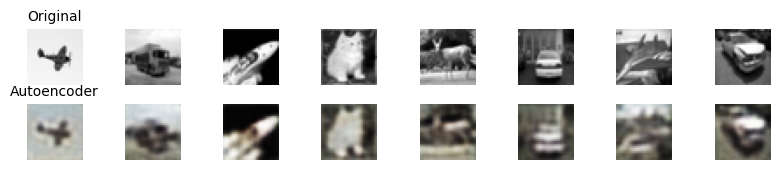

In [33]:
# Plotting images
plot_images([autoencoder_gray_color], ['Autoencoder'], images = x_test_gray, n = 8, graymap=True)

We observed that the color reconstruction is imperfect. The model captures the basic color hints for the sky and grass, but the final output is of poor quality and lacks definition.

### Predicting chrominance

For this approach we are gonna separate the luminance and the chrominance of the image. As input we are gonna use the luminance and for calculating loss the training process will use the chrominance as target.

For this scenario the autoeconder will receive just 1 channel as input and 2 channels as output.

In [37]:
# Getting grayscale and chrominance
xl_train, xab_train = rgb_to_lab(x_train)
xl_val, xab_val = rgb_to_lab(x_val)
xl_test, xab_test = rgb_to_lab(x_test)

Now we can build the autoencoder. Here we only need 1 channel as input the lightness value. For the output layer we need 2 channels which are the chrominance values.

In [38]:
autoencoder_lab = build_autoencoder(input_shape = (32, 32, 1), output_channels = 2)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 32, 32, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 12)     │           876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 12)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 16)       │         1,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_18 (UpSampling2D) │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 16, 16, 12)     │         1,740 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_19 (UpSampling2D) │ (None, 32, 32, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 2)      │           218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,658 (18.20 KB)

 Trainable params: 4,658 (18.20 KB)

 Non-trainable params: 0 (0.00 B)

For the training step we will set that luminance values (xl_train) will be used as input of the autoencoder, and chrominance values (xab_train) will be used as target. For validation set we applied the same transformation.

In [40]:
train_history_lav = train_autoencoder(autoencoder_lab, xl_train, xl_val, epochs, xab_train, xab_val)

Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
def evaluate_autoencoder2(autoencoder, xl_test, xab_test):
    # Evaluate the autoencoder
    test_loss = autoencoder.evaluate(xl_test, xab_test)
    print(f'Test Loss: {test_loss}')

    return test_loss

In [46]:
# Evaluate the autoencoder
test_loss = evaluate_autoencoder2(autoencoder_lab, xl_test, xab_test)

# Store results
exp_name = 'Predicting chrominance'
params = {'input_shape':(32, 32, 1),
          'output_channels':2}
results_list.append({
    'Experiment': exp_name,
    'Test MSE': test_loss,
    'Val Loss': train_history_lav.history['val_loss'][-1],
    'History': train_history_lav.history,
    'Parameters': str(params)
})

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0024
Test Loss: 0.0023501927498728037


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


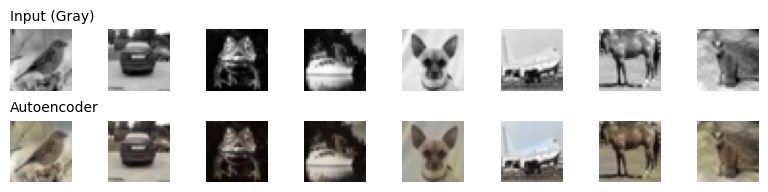

In [48]:
import random
plot_lab_images(autoencoder_lab, x_test)

With this last strategy we can realize that we get a better result on colorizing grayscale images.

### Comparative

In [49]:
# Show Table
df_current = pd.DataFrame(results_list)
exp_list = ['Baseline', 'Color image as target', 'Predicting chrominance']
df_current = df_current[df_current['Experiment'].isin(exp_list)]
display(df_current)

,Experiment,Test MSE,Val Loss,History,Parameters
0,Baseline,0.005197,0.005168,"{'loss': [0.022563539445400238, 0.010303162038...","{'input_shape': '(32, 32, 3)', 'latent_filter'..."
7,Color image as target,0.004766,0.009936,"{'loss': [0.028129223734140396, 0.014481067657...","{'input_shape': (32, 32, 1)}"
8,Predicting chrominance,0.002350,0.002418,"{'loss': [0.0027461261488497257, 0.00259828288...","{'input_shape': (32, 32, 1), 'output_channels'..."


In [51]:
# Plot comparison
plot_comparison_full(df_current, experiment="Colorization Autoencoder Variations")

In [52]:
with open('experiments.pkl', 'wb') as f:
    pickle.dump(results_list, f)